In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from tqdm import tqdm
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from trainer import Trainer
from utils import Logger
import importlib
import math
import torchvision
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
print("Reload complete")

Modules loaded
Reload complete


In [9]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics

    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    #print(os.path.isfile(data_loader.dataset))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    if torch.cuda.is_available():
        print(torch.cuda.get_device_name(0))
    else:
        print("Using CPU to train")
    
    visualizeDataset(data_loader)
    visualize1(data_loader)
    
    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for 'nll_loss'
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    trainer = Trainer(model, loss, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)

    #trainer.train()

def visualizeDataset(dataloader):
    images, labels = next(iter(dataloader))
    plt.imshow(torchvision.utils.make_grid(images, nrow=8).permute(1, 2, 0))
    
def visualize1(dataloader):
    images, labels = next(iter(dataloader))
    fig = plt.figure(figsize=(40, 40))
    batch = math.floor(math.sqrt(dataloader.batch_size))
    for i in range(len(images)):
        a = fig.add_subplot(batch,batch,i+1)
        imgplot = plt.imshow(images[i].permute(1,2,0).numpy())
        plt.axis('off')
        a.set_title("Label = " +str(labels[i].numpy()), fontsize=30)

In [10]:
config_file = 'config_template.json'
# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

templateModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=43, bias=True)
)
Trainable parameters: 64811
Using CPU to train


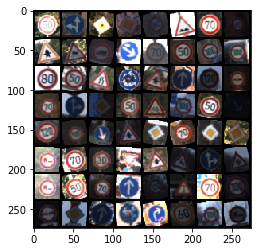

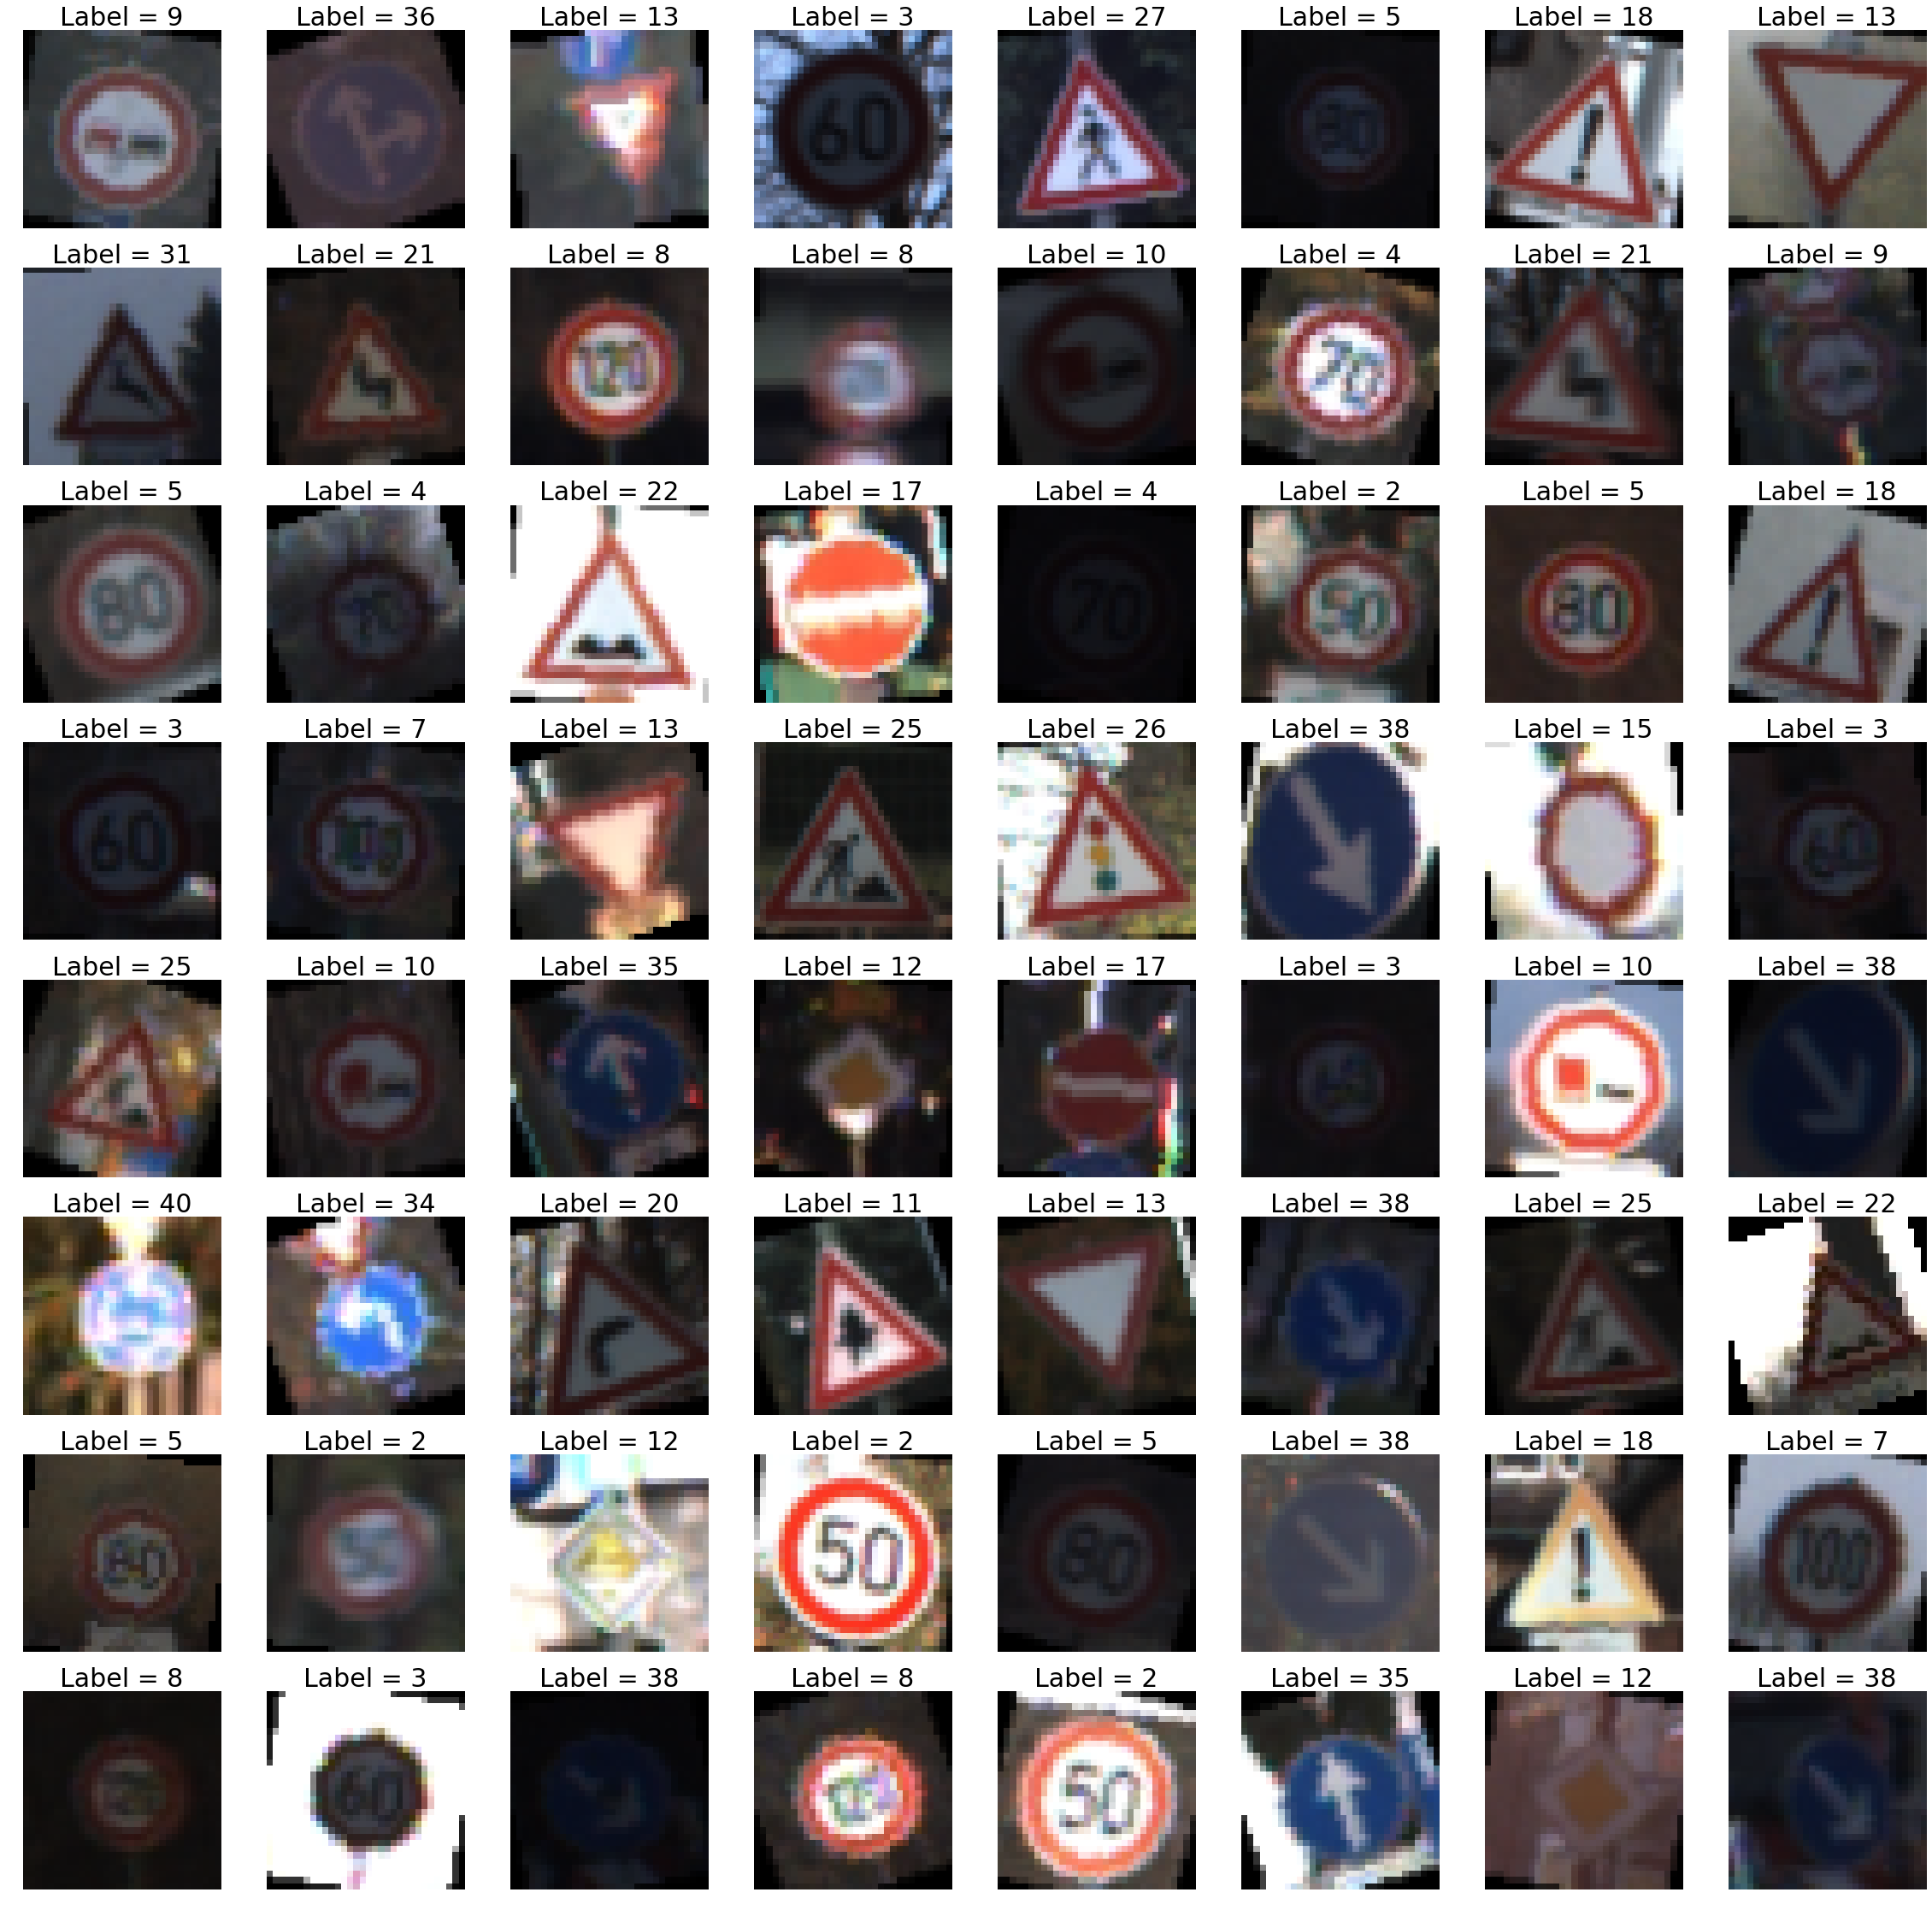

In [11]:
#Train the network
main(config, None)

In [119]:
resume = "saved/cifar_fromTAR/0520_203356/model_best.pth"

print(os.path.isdir("saved/cifar_fromTAR/0520_203356"))
print(os.path.exists(resume))

#config = torch.load("saved/Mnist_LeNet/0414_203632/config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


  0%|          | 0/20 [00:00<?, ?it/s]

Cifar10Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Trainable parameters: 62006
Tesla K80


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  5%|▌         | 1/20 [00:00<00:05,  3.69it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 15%|█▌        | 3/20 [00:00<00:03,  4.68it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 25%|██▌       | 5/20 [00:00<00:02,  5.75it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


100%|██████████| 20/20 [00:01<00:00, 12.47it/s]


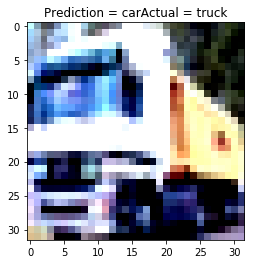

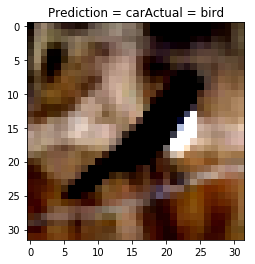

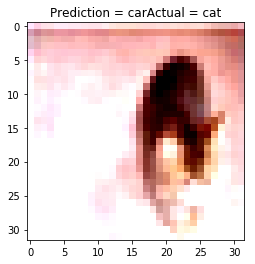

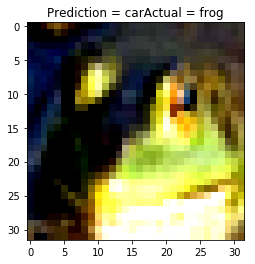

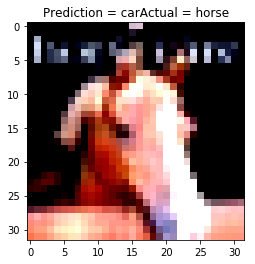

num samples = 10000
{'loss': -314659231546055.06, 'my_metric2': 0.3022, 'my_metric': 0.0974}
My_metric is accuracy, my_metric2 is top-3 accuracy


In [120]:
#Test
main2(config, resume)